In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path('.').resolve().parent))

In [14]:
from tqdm import tqdm
import wandb

import pandas as pd
import numpy as np
import torch
from einops import repeat

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import seaborn as sns

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import r2_score

from posenc.datasets.chestx import ChestXDataModule
from posenc.datasets.echonet import EchoNetDataset
from posenc.nets.positional_encodings import PositionalEmbedding

sns.set_context("paper", font_scale=1.5)

# Figure 1

In [15]:
# chestx = ChestXDataModule(
#     task="binary", batch_size=128, num_workers=32, do_cutmix=False, do_mixup=False
# )
# chestx.setup()
# mean_image = torch.zeros(224, 224)
# for i in range(100):
#     for _ in range(5):
#         mean_image += chestx.valid[i][0][0]
# mean_image /= 500
# mean_image = mean_image.numpy()

# with open('../results/mean_chestx_image.npy', 'wb') as f:
#     np.save(f, mean_image)

mean_image = np.load("../results/mean_chestx_image.npy")

In [16]:
def show_positional_similarity(grid_size, pos_embedding, idx, cosine=False):
    # Extract the query embedding and add a batch dimension
    query = pos_embedding[idx, :].unsqueeze(0)  # Shape: [1, embedding_dim]
    
    # Compute dot products between query and all embeddings
    similarity = torch.matmul(query, pos_embedding.T)  # Shape: [1, num_embeddings]

    if cosine:
        # Compute L2 norms for the query and each positional embedding
        query_norm = torch.norm(query, p=2, dim=1)  # Shape: [1]
        pos_norms = torch.norm(pos_embedding, p=2, dim=1)  # Shape: [num_embeddings]
        
        # Compute cosine similarities (dot product divided by product of norms)
        similarity = similarity / (query_norm * pos_norms)  # Shape: [1, num_embeddings]
    
    # Reshape to match grid dimensions and return
    return similarity.view(*grid_size)

# Get the 'Reds' colormap
base_cmap = get_cmap('magma')

# Define a function to modify the alpha channel
def modified_colormap(cmap, alpha_func):
    colors = cmap(np.linspace(0, 1, 256))  # Get the original colormap
    alphas = alpha_func(np.linspace(0, 1, 256))  # Alpha increases as values get smaller
    colors[:, -1] = alphas  # Modify the alpha channel
    return mcolors.ListedColormap(colors)

# Define the alpha function (linear scaling from 0 to 0.8)
def alpha_func(values):
    return 0.8 * values  # Ensures alpha is 0 at the smallest value and 0.8 at the largest

# Create the new colormap
custom_cmap = modified_colormap(base_cmap, alpha_func)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


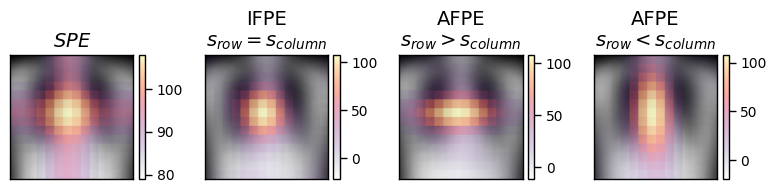

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(8, 2))

# Define settings for each subplot
configs = [
    ("sincos", None, "$SPE$", 90),
    ("isofpe", [1., 1.], "IFPE\n${s_{row} = s_{column}}$", 90),
    ("isofpe", [1.125, 0.497], "AFPE\n${s_{row} > s_{column}}$", 90),
    ("isofpe", [0.497, 1.125], "AFPE\n${s_{row} < s_{column}}$", 90)
]

for ax, (method, variance_factors, title, index) in zip(axes, configs):
    # Generate positional embedding
    pembed = PositionalEmbedding(method, 224, 16, 216, 2, variance_factors=variance_factors)
    pembed = pembed.positions.clone().detach()[0]

    # Compute similarity
    sim = show_positional_similarity([14, 14], pembed, index)
    sim = repeat(sim, "h w -> (h r1) (w r2)", r1=16, r2=16)

    # Plot
    im1 = ax.imshow(mean_image, cmap="gray")
    im2 = ax.imshow(sim, cmap=custom_cmap)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Set title
    ax.set_title(title, fontsize=14)

    # Add colorbar
    cbar = fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

# Adjust layout
plt.tight_layout()
plt.savefig("../results/iso_pe_comparison_2d_chestx.eps", dpi=300)
plt.show()

# Figure 2

In [22]:
# api = wandb.Api()
# runs = api.runs("echonetreg")

# spacetime_df = []
# for run in tqdm(runs):
    
#     if not run.name.startswith("Trial"):
#         continue
    
#     variance_factors = run.config.get("variance_factors")
    
#     if variance_factors is None:
#         continue

#     time_var = variance_factors[0]
#     space_var = variance_factors[1]
#     isotropy = time_var / space_var 

#     r2 = run.history().get("valid/r2")

#     if r2 is None:
#         continue

#     r2 = r2.max()
    
#     res.append([time_var, space_var, r2, isotropy])
# spacetime_df = pd.DataFrame(spacetime_df, columns=["time_var", "space_var", "r2", "isotropy"])
# spacetime_df = spacetime_df[spacetime_df.r2 > 0.5]


def load_chestx_df(path="/sc-scratch/sc-scratch-gbm-radiomics/posenc/chest_all.csv"):
    # Load dataframe
    df = pd.read_csv(path)
    
    # Basic filtering and dtype processing
    df = df[df.epoch == 49]
    df["Column Variance"] = df.variance_factors.apply(lambda x: eval(x)[1])
    df["Row Variance"] = df.variance_factors.apply(lambda x: eval(x)[0])
    df["Isotropy"] = df["Row Variance"] / df["Column Variance"]
    df = df.rename(columns=lambda x: x.split("/")[1] if len(x.split("/")) > 1 else x)
    
    # Melt the DataFrame
    id_vars = ["Name", 'variance_factors', 'epoch', 'Column Variance', 'Row Variance', 'Isotropy']
    df_melted = df.melt(id_vars=id_vars, var_name="metric_class", value_name="value")
    
    # Extract metric and class using regex
    df_melted[["metric", "class"]] = df_melted["metric_class"].str.extract(r"(\w+)_(.+)")
    
    # Compute F1
    _df_f1 = df_melted.loc[df_melted["metric"] == "precision"].reset_index().copy()
    
    f1 = (2 * df_melted.loc[df_melted["metric"] == "precision", "value"].values * df_melted.loc[df_melted["metric"] == "recall", "value"].values / (
        df_melted.loc[df_melted["metric"] == "precision", "value"].values + df_melted.loc[df_melted["metric"] == "recall", "value"].values
    ))
    _df_f1["metric"] = "f1"
    _df_f1["value"] = f1
    
    max_values = _df_f1.groupby("class")["value"].max().dropna().reset_index()
    
    # Get corresponding isotropy values
    isotropy_values = _df_f1.loc[_df_f1.groupby("class")["value"].idxmax().dropna(), ["class", "Isotropy", "Row Variance", "Column Variance"]]
    
    # Merge max values and isotropy values
    plot_df = max_values.merge(isotropy_values, on="class")

    # Separate the mean class for special styling  
    mean_point = plot_df[plot_df["class"] == "mean"]
    mean_point.loc[:, "Isotropy"] = 0.497 / 1.125 # Isotropy of best model based on validation performance
    
    other_points = plot_df[plot_df["class"] != "mean"]

    return mean_point, other_points, plot_df, df


In [26]:
objdet = pd.read_csv("/sc-scratch/sc-scratch-gbm-radiomics/posenc/chestx/ObjectDetection/train.csv")
mean_point, other_points, plot_df, df = load_chestx_df()

labels = set(objdet.label).intersection(set(other_points["class"]))

other_points_filtered = other_points[other_points['class'].isin(labels)]
objdet = objdet[objdet.label.isin(labels)]

objdet_sum = objdet.loc[:, ["w", "h", "label"]].groupby("label", as_index=False).agg(["mean", "std"])
objdet_sum.columns = [f"{col}_{stat}" if col != "label" else col for col, stat in objdet_sum.columns]

objdet_sum.loc[:, "iso"] = objdet_sum.h_mean / objdet_sum.w_mean

invalid value encountered in divide


In [27]:
df_final = objdet_sum.merge(other_points_filtered.drop(columns="value").rename({"class": "label"}, axis=1))

In [28]:
# df_final = df_final.merge(legend_df)

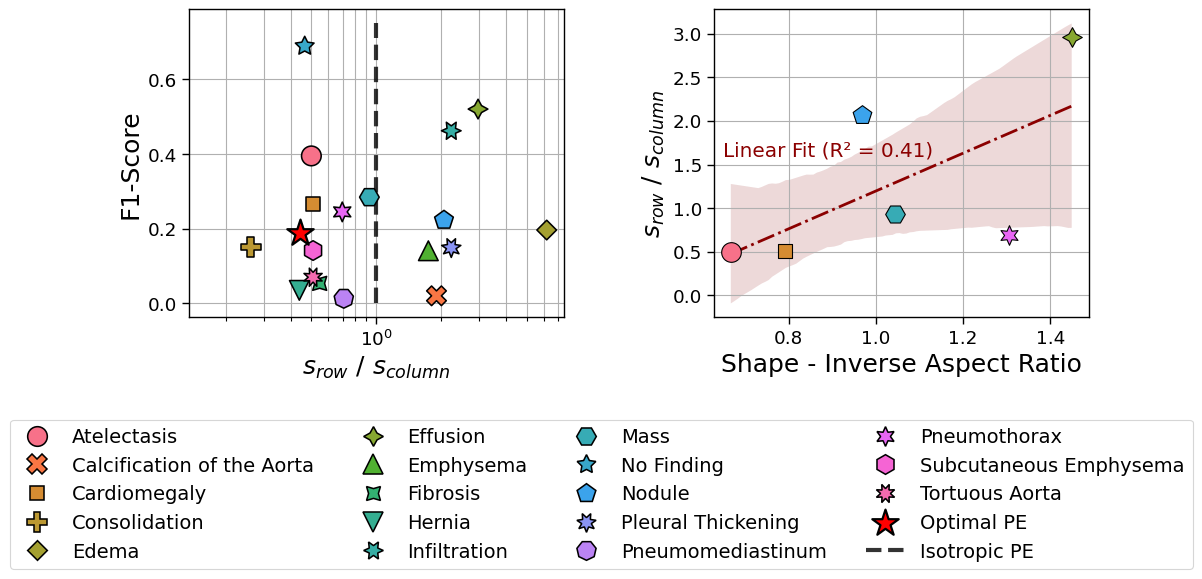

In [29]:
# Define font sizes
fontsize = 18
labelsize = 14

# Define highlight point style
best_point_kwargs = dict(
    color="red", edgecolor="black", s=400, marker="*", label="Optimal PE", zorder=4
)

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Plot first scatter plot (ChestX)
sns.scatterplot(
    data=other_points,
    x="Isotropy", y="value", hue="class", style="class",
    ax=axs[0], s=200, edgecolor="black", zorder=3
)
sns.scatterplot(data=mean_point, x="Isotropy", y="value", ax=axs[0], **best_point_kwargs)

# Formatting first plot
# axs[0].set_title("ChestX", fontsize=fontsize)
axs[0].set_xlabel(r"$s_{row}$ / $s_{column}$", fontsize=fontsize)
axs[0].set_ylabel("F1-Score", fontsize=fontsize)
axs[0].set_xscale("log")
axs[0].vlines(1, 0, 0.75, color="black", ls="--", lw=3, alpha=0.8, label="Isotropic PE", zorder=2)

# Set symmetric log limits around x=1
x_min, x_max = plot_df["Isotropy"].min(), plot_df["Isotropy"].max()
log_range = max(abs(np.log10(x_max)), abs(np.log10(x_min))) * 1.1
axs[0].set_xlim(10**-log_range, 10**log_range)

# Adjust legend and grid
axs[0].legend(loc="upper center", bbox_to_anchor=(1.1, -0.3), ncol=4, fontsize=labelsize, frameon=True)
axs[0].grid(which="both")

# Get legend parameters
handles, labels = axs[0].get_legend_handles_labels()
hue_legend = {
    label: handle.get_facecolor()[0] if isinstance(handle, Patch) else handle.get_color()
    for handle, label in zip(handles, labels)
    if label in other_points["class"].unique()
}
style_legend = {
    label: handle.get_marker()
    for handle, label in zip(handles, labels)
    if isinstance(handle, Line2D) and label in other_points["class"].unique()
}

all_labels = set(hue_legend.keys()).union(style_legend.keys())

# Create dataframe
legend_df = pd.DataFrame([
    {
        "label": label,
        "hue": hue_legend.get(label, None),
        "style": style_legend.get(label, None)
    }
    for label in all_labels
])
legend_df = legend_df[legend_df.label.isin(labels)]
df_final = df_final.merge(legend_df)

# Formatting second plot
ax = axs[1]
for label, group in df_final.groupby("label"):
    ax.scatter(
        x=group["iso"],
        y=group["Isotropy"],
        color=group["hue"].iloc[0],
        marker=group["style"].iloc[0],
        s=200,
        edgecolor="black",
        label=label,
        zorder=3
    )

# Overlay Seaborn regression line
sns.regplot(
    data=df_final,
    x="iso", y="Isotropy",
    scatter=False,
    ax=ax,
    line_kws={"color": "darkred", "linestyle": "-.", "linewidth": 2},
    ci=90
)

# Calculate R² manually
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

X = df_final["iso"].values.reshape(-1, 1)
y = df_final["Isotropy"].values
model = LinearRegression().fit(X, y)
r2 = r2_score(y, model.predict(X))

# Annotate R²
ax.annotate(f"Linear Fit (R² = {r2:.2f})", xy=(0.65, 1.6), color="darkred")

# Labels and formatting
ax.set_xlabel("Shape - Inverse Aspect Ratio", fontsize=fontsize)
ax.set_ylabel(r"$s_{row}$ / $s_{column}$", fontsize=fontsize)
plt.grid(True)

# Show plot
fig.subplots_adjust(left=0, right=1, wspace=0.4)  # Adjust horizontal spacing
# plt.savefig("../results/optimal_afpe.eps", dpi=300, bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


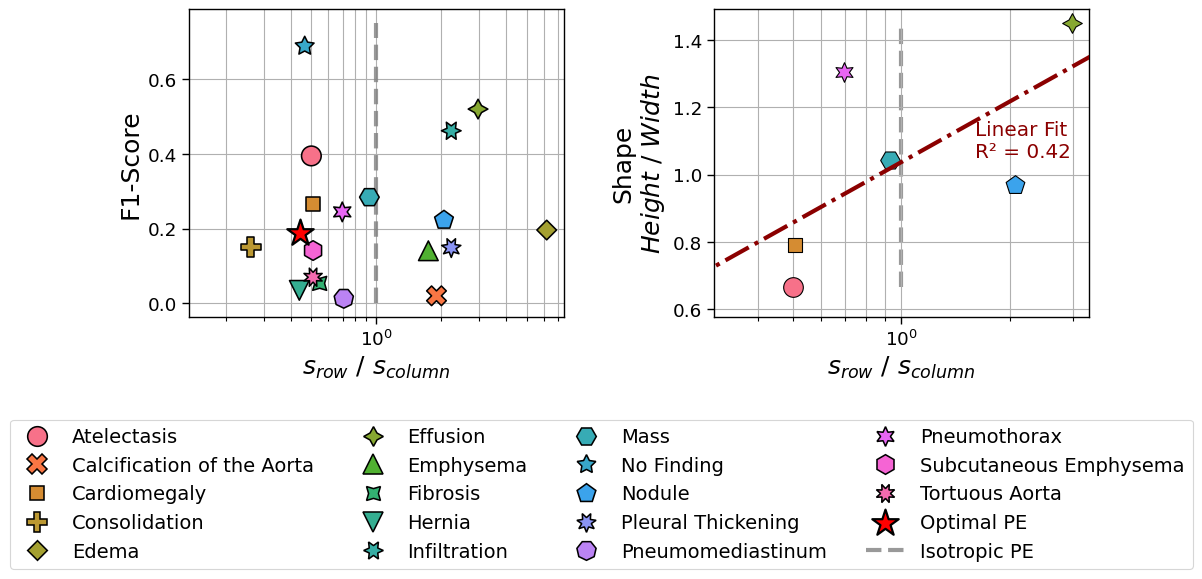

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Define font sizes
fontsize = 18
labelsize = 14

# Define highlight point style
best_point_kwargs = dict(
    color="red", edgecolor="black", s=400, marker="*", label="Optimal PE", zorder=4
)

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# ==== First subplot (ChestX) ====
sns.scatterplot(
    data=other_points,
    x="Isotropy", y="value", hue="class", style="class",
    ax=axs[0], s=200, edgecolor="black", zorder=3
)
sns.scatterplot(data=mean_point, x="Isotropy", y="value", ax=axs[0], **best_point_kwargs)

axs[0].set_xlabel(r"$s_{row}$ / $s_{column}$", fontsize=fontsize)
axs[0].set_ylabel("F1-Score", fontsize=fontsize)
axs[0].set_xscale("log")
axs[0].vlines(1, 0, 0.75, color="gray", ls="--", lw=3, alpha=0.8, label="Isotropic PE", zorder=2)

# Symmetric log x-limits around 1
x_min, x_max = plot_df["Isotropy"].min(), plot_df["Isotropy"].max()
log_range = max(abs(np.log10(x_max)), abs(np.log10(x_min))) * 1.1
axs[0].set_xlim(10**-log_range, 10**log_range)

axs[0].legend(loc="upper center", bbox_to_anchor=(1.1, -0.3), ncol=4, fontsize=labelsize, frameon=True)
axs[0].grid(which="both")

# ==== Second subplot (EchoNet) with switched x and y axes and log-scale x-axis ====

# Filter data to ensure only positive values on the new x-axis (which was y before)
df_final = df_final[df_final["Isotropy"] > 0].copy()

ax = axs[1]
for label, group in df_final.groupby("label"):
    ax.scatter(
        x=group["Isotropy"],  # switched: y before -> x now
        y=group["iso"],       # switched: x before -> y now
        color=group["hue"].iloc[0],
        marker=group["style"].iloc[0],
        s=200,
        edgecolor="black",
        label=label,
        zorder=3
    )

# Log-scale on the new x-axis (which is Isotropy)
ax.set_xscale("log")

# Regression on log10(x) predicting y
X_log = np.log10(df_final["Isotropy"].values).reshape(-1, 1)
y = df_final["iso"].values
model = LinearRegression().fit(X_log, y)
r2 = r2_score(y, model.predict(X_log))

# Regression line plotted in original space:
x_range_log = np.linspace(np.log10(df_final["Isotropy"].min()) - 0.4, np.log10(df_final["Isotropy"].max()) + 0.1, 200)
x_range = 10 ** x_range_log
y_pred = model.predict(x_range_log.reshape(-1, 1))
ax.plot(x_range, y_pred, linestyle="-.", linewidth=3, color="darkred", label="Linear Fit", zorder=4)

# Annotate R²
ax.annotate(f"Linear Fit\nR² = {r2:.2f}", xy=(1.6, 1.05), color="darkred")

# Axis labels (switched)
ax.set_xlabel(r"$s_{row}$ / $s_{column}$", fontsize=fontsize)
ax.set_ylabel("Shape\n$Height$ / $Width$", fontsize=fontsize)

# Vertical reference line at x=1 (was horizontal at y=1 before)
ax.vlines(1, df_final["iso"].min(), df_final["iso"].max(), color="gray", ls="--", lw=3, alpha=0.8, zorder=1)

# Symmetric log x-limits around x=1
x_min, x_max = df_final["Isotropy"].min(), df_final["Isotropy"].max()
log_x_range = max(abs(np.log10(x_max)), abs(np.log10(x_min))) * 1.1
ax.set_xlim(10**-log_x_range, 10**log_x_range)

ax.grid(which="both")


# Final layout
fig.subplots_adjust(left=0, right=1, wspace=0.4)
plt.savefig("../results/optimal_afpe_shape.eps", dpi=300, bbox_inches="tight")
plt.show()

# Figure 3

## EchoNet sample video

In [83]:
echod = EchoNetDataset(output_variable="edv")

In [84]:
video = torch.load(echod[10]["image"], weights_only=False).numpy().squeeze()

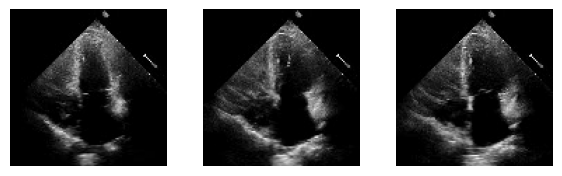

In [86]:
fig, axs = plt.subplots(ncols=3, figsize=(6, 2))

video_slices = [16, 24, 32]

for i, ax in enumerate(axs):
    ax.imshow(video[video_slices[i]], cmap="gray")
    ax.set_axis_off()

plt.tight_layout()
plt.savefig("../results/figures/esf_edv.png", dpi=300)
plt.show()

## EchoNet scale optimization

In [11]:
# Loading the data
spacetime_df = pd.read_csv("../results/echonet_isotropy.csv", index_col=0)

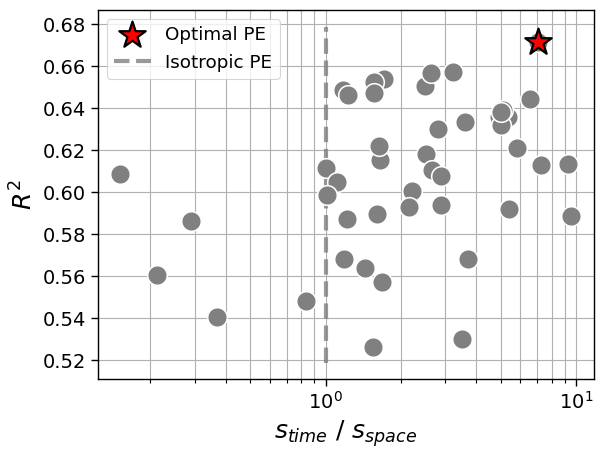

In [12]:

# Define font sizes
fontsize = 18
labelsize = 14

# Define highlight point style
best_point_kwargs = dict(
    color="red", edgecolor="black", s=400, marker="*", label="Optimal PE", zorder=4
)

ax = plt.subplot()
sns.scatterplot(data=spacetime_df, x="isotropy", y="r2", color="gray", ax=ax, s=200, zorder=3)
sns.scatterplot(spacetime_df.loc[[spacetime_df["r2"].idxmax()]], x="isotropy", y="r2", legend=False, **best_point_kwargs)

# Formatting second plot
ymin, ymax = ax.get_ylim()
ax.set_xscale("log")
ax.vlines(1, ymin, ymax, color="gray", ls="--", lw=3, alpha=0.8, label="Isotropic PE", zorder=2)
ax.grid(which="both")
ax.set_ylabel("$R^2$", fontsize=fontsize)
ax.set_xlabel("$s_{time}$ / $s_{space}$", fontsize=fontsize)
ax.tick_params(axis='both', labelsize=labelsize)
plt.legend()
plt.savefig("../results/figures/echonet_finding_best_model.svg", dpi=300, bbox_inches="tight")
plt.show()

# Additional Figures

In [2]:
from pathlib import Path
from collections import defaultdict
from posenc.modules.vision_transformer import ViTMultiClsModule

from torchmetrics.classification import BinaryAUROC, BinaryF1Score, BinaryAveragePrecision

In [3]:
all_models = Path("/sc-projects/sc-proj-gbm-radiomics/posenc/checkpoints/chestxmulti/isofpe")
MODELS = {p.parent.name: p for p in all_models.glob("*/*")}
DEVICE = "cuda"

In [4]:
@torch.no_grad()
def predict(model, loader):
    """Prediction generator given a dataloader and model."""
    model.eval()
    for (x, y) in tqdm(loader):
        y_hat = model(x.to(DEVICE)).cpu()
        yield y_hat.flatten(), y.flatten()

def generate_results(save_path=None, num_workers=32):
    """Takes a model_name:model_path dictonary and an output path to generate results."""

    chestx = ChestXDataModule(
        task="multilabel", batch_size=128, num_workers=num_workers, do_cutmix=False, do_mixup=False
    )
    chestx.setup()
    loader = chestx.test_dataloader()
    
    res = defaultdict(list)
    nsamples = 0
    for model_name, path in MODELS.items():

        torch.manual_seed(4242)
        model = ViTMultiClsModule.load_from_checkpoint(path, map_location=torch.device(DEVICE))
        
        print("Evaluating", model_name)
        total_samples = 0
        for y_hat, y in predict(model, loader):
            n_labels = len(y_hat)
            n_samples = n_labels // 20
            
            res["logits"] += y_hat.tolist()
            res["pred"] += y_hat.sigmoid().tolist()
            res["model"] += [model_name] * n_labels
            res["y"] += y.tolist()
            res["label"] += chestx.test.labels * n_samples
            # y has shape (samples, 20). We keep track of what sample every class prediction belongs to.
            res["sample"] += np.repeat(np.arange(total_samples, total_samples + n_samples), 20).tolist()
            total_samples += n_samples

    df = pd.DataFrame(res)

    if save_path is not None:
        df.to_csv(save_path)

    return df

In [79]:
# df = generate_results()

# df_spe = pd.read_csv("../results/chestxmulti_final_test_results.csv", index_col=0)
# df_spe = df_spe[df_spe.model == "spe"]
# df_final = pd.concat([df_spe, df])

# per_class_results = defaultdict(list)
# auroc_fn = BinaryAUROC()
# f1_fn = BinaryF1Score()
# map_fn = BinaryAveragePrecision()

# for model in df_final.model.unique():
#     for label, group in df_final[df_final.model == model].groupby("label"):
#         y_true = torch.tensor(group.y.values, dtype=torch.int)
#         y_pred = torch.tensor(group.pred.values, dtype=torch.float)

#         auroc = auroc_fn(y_pred, y_true)
#         f1 = f1_fn(y_pred, y_true)
#         map_v = map_fn(y_pred, y_true)

#         per_class_results["model"].append(model)
#         per_class_results["label"].append(label)       
#         per_class_results["auroc"].append(auroc.item())
#         per_class_results["f1"].append(f1.item())
#         per_class_results["map"].append(map_v.item())

# per_class_results = pd.DataFrame(per_class_results)
# per_class_results["model_type"] = "SPE"
# per_class_results.loc[per_class_results.model != "spe", "model_type"] = "AFPE"
# per_class_results.to_csv("../results/per_class_results_chestx_spe_vs_afpe.csv")

per_class_results = pd.read_csv("../results/per_class_results_chestx_spe_vs_afpe.csv", index_col=0)

In [17]:
per_class_results = defaultdict(list)
auroc_fn = BinaryAUROC()
f1_fn = BinaryF1Score()
map_fn = BinaryAveragePrecision()

for model in df_final.model.unique():
    for label, group in df_final[df_final.model == model].groupby("label"):
        y_true = torch.tensor(group.y.values, dtype=torch.int)
        y_pred = torch.tensor(group.pred.values, dtype=torch.float)

        auroc = auroc_fn(y_pred, y_true)
        f1 = f1_fn(y_pred, y_true)
        map_v = map_fn(y_pred, y_true)

        per_class_results["model"].append(model)
        per_class_results["label"].append(label)       
        per_class_results["auroc"].append(auroc.item())
        per_class_results["f1"].append(f1.item())
        per_class_results["map"].append(map_v.item())

per_class_results = pd.DataFrame(per_class_results)
per_class_results["model_type"] = "SPE"
per_class_results.loc[per_class_results.model != "spe", "model_type"] = "AFPE"

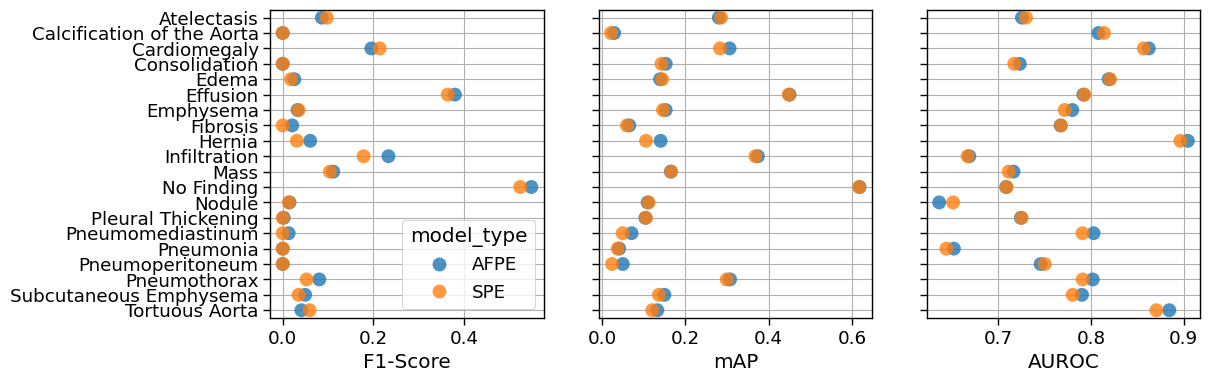

In [18]:
fig, axs = plt.subplots(1, 3, sharey=True)

fig.set_size_inches(12, 4)

xlabels = {
    "f1": "F1-Score",
    "map": "mAP",
    "auroc": "AUROC"
}

for i, (ax, metric) in enumerate(zip(axs, ["f1", "map", "auroc"])):
    legend = i == 0
    sns.stripplot(per_class_results.groupby(["label", "model_type"], as_index=False).max(), y="label", x=metric, hue="model_type", jitter=False, alpha=0.8, s=10, ax=ax, legend=legend)
    # plt.xticks(rotation=90)
    ax.set_ylabel("")
    ax.set_xlabel(xlabels[metric])
    ax.grid()

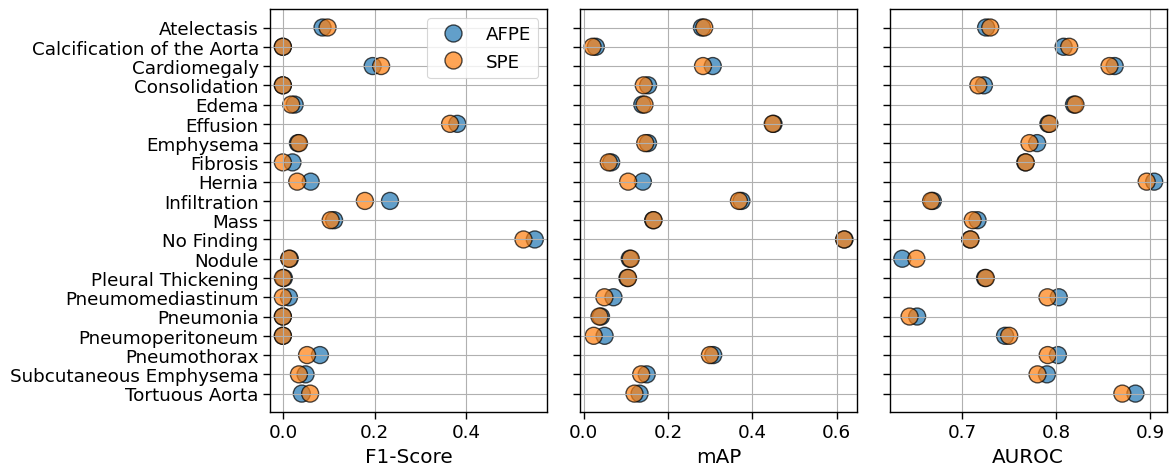

In [11]:
fig, axs = plt.subplots(1, 3, sharey=True)

fig.set_size_inches(12, 5)

xlabels = {
    "f1": "F1-Score",
    "map": "mAP",
    "auroc": "AUROC"
}

for i, (ax, metric) in enumerate(zip(axs, ["f1", "map", "auroc"])):
    
    ac = sns.scatterplot(per_class_results.groupby(["label", "model_type"], as_index=False).max(), y="label",
                    x=metric, hue="model_type", alpha=0.7, s=150, ax=ax, legend=(i == 0), edgecolor="black")
    # plt.xticks(rotation=90)
    ax.set_ylabel("")
    ax.set_xlabel(xlabels[metric])
    ax.grid()

axs[0].legend(title="")
plt.tight_layout()
plt.show()


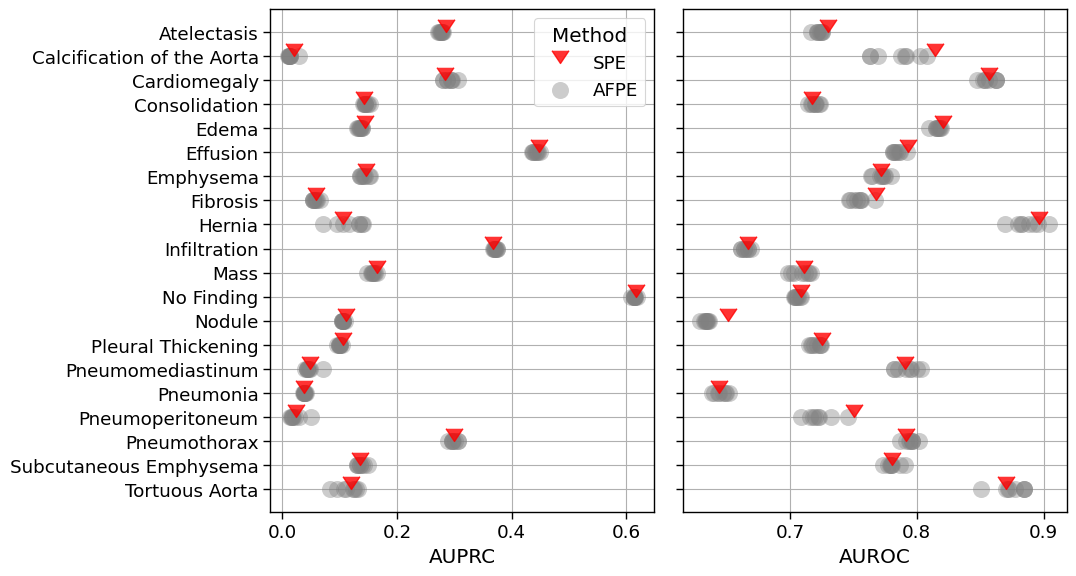

In [37]:
fig, axs = plt.subplots(1, 2, sharey=True)

fig.set_size_inches(11, 6)

xlabels = {
    "f1": "F1-Score",
    "map": "AUPRC",
    "auroc": "AUROC"
}

for i, (ax, metric) in enumerate(zip(axs, ["map", "auroc"])):
    
    ac = sns.scatterplot(per_class_results[per_class_results.model_type=="SPE"], y="label",
                    x=metric, color="red", alpha=0.8, s=150, ax=ax, legend=(i == 0), zorder=4, marker=7, label="SPE")
    ac = sns.scatterplot(per_class_results[per_class_results.model_type=="AFPE"], y="label",
                    x=metric, color="gray", alpha=0.4, s=150, ax=ax, legend=(i == 0), lw=0, zorder=3, label="AFPE")
    ax.set_ylabel("")
    ax.set_xlabel(xlabels[metric])
    ax.grid()

axs[0].legend(title="Method")
plt.tight_layout()
plt.savefig("../results/figures/spe_vs_afpe_chestx.svg", dpi=300)
# plt.show()